In [1]:
import pandas as pd 
import nltk,string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import re



Using TensorFlow backend.


In [ ]:
data = pd.read_excel("wpcoins.xlsx")
data.head()

In [ ]:
#create column called risk and give value 0 if the rating of the coin is greater than 3 
#and value 1 of the coin rating is 3 or lesser.
data.loc[data['rating'] > 3, 'risk'] = 0
data.loc[data['rating'] <= 3, 'risk'] = 1

In [4]:
#example of the dataset
data[860:870]

,name,rating,about,whitepaper,risk
860,RENC,3.2,About RENC\nRentalCurrency (RENC) Coin is a sp...,renc white paper\n\n\nrenc white paper \n\n \n...,0.0
861,rLoop,3.6,About rLoop\nThe rLoop Network is a globally d...,1\n\na decentralised and crowdsourced \nengine...,0.0
862,Space.Cloud.Unit,3.2,About Space.Cloud.Unit\nSpace.Cloud.Unit – or ...,space.cloud.unit \n \n\nthe first b2b cloud ma...,0.0
863,Universal Protocol,3.2,About Universal Protocol\nThe Universal Protoc...,"the universal protocol platform, a transformat...",0.0
864,VideoCoin,3.2,About VideoCoin\nVideo constitutes a staggerin...,"videocoin - a decentralized video encoding,\ns...",0.0
865,Yezcoin,3.0,About Yezcoin\nWith our full awareness of the ...,yezcoin white paper_short.pdf - google drive\n...,1.0
866,Aexon,3.0,About Aexon\nOur pledge to purchasers of the A...,one \ncommunity \ntoken \n\nempowering the \nc...,1.0
867,Armacoin,2.8,About Armacoin\nOur Armacoin GZM coin is speci...,hello!\nblockchain\nadvertising token \narmaco...,1.0
868,Bankaero,3.0,About Bankaero\nToday’s world is difficult to ...,whitepaper\n2019\n\n\n\n2table of contents\n\n...,1.0
869,BlockClick,3.0,About BlockClick\nHowever modernized it may se...,smart contract\ncompleted\n\nbuyer seller\n\n7...,1.0


In [5]:
#drop rows with nan values
data=data.dropna()

In [16]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

# set the maximum number of words to be used
MAX_NB_WORDS=10000

# set sentence/document length as most documents had white paper length between 3000 and 4000
MAX_DOC_LEN=5000

# get a Keras tokenizer and 
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=False)

#fit the tokenizer to the data
tokenizer.fit_on_texts(data["whitepaper"])


In [17]:

# convert each document to a list of word index as a sequen
sequences = tokenizer.\
texts_to_sequences(data["whitepaper"])

# pad all sequences into the same length 
# if a sentence is longer than maxlen, pad it in the right
# if a sentence is shorter than maxlen, truncate it in the right
padded_sequences = pad_sequences(sequences, \
                                 maxlen=MAX_DOC_LEN, \
                                 padding='post', \
                                 truncating='post')


In [18]:
from sklearn.model_selection import train_test_split

#split the data into test and training set
X_train, X_test, y_train, y_test = train_test_split(\
                        padded_sequences, data['risk'],\
                        test_size=0.1, random_state=1)

In [21]:

from keras.layers import Embedding, Dense, Conv1D, MaxPooling1D, \
Dropout, Activation, Input, Flatten, Concatenate
from keras.models import Model

EMBEDDING_DIM=150

# 1 dimension array with integers
main_input = Input(shape=(MAX_DOC_LEN,), \
                   dtype='int32', name='main_input')

embed_1 = Embedding(input_dim=MAX_NB_WORDS+1, \
                    output_dim=EMBEDDING_DIM, \
                    input_length=MAX_DOC_LEN,\
                    name='embedding')(main_input)


conv1d_1= Conv1D(filters=64, kernel_size=1, \
                 name='conv_unigram',\
                 activation='relu')(embed_1)

pool_1 = MaxPooling1D(MAX_DOC_LEN-1+1, \
                      name='pool_unigram')(conv1d_1)

flat_1 = Flatten(name='flat_unigram')(pool_1)

conv1d_2= Conv1D(filters=64, kernel_size=2, \
                 name='conv_bigram',\
                 activation='relu')(embed_1)
pool_2 = MaxPooling1D(MAX_DOC_LEN-2+1, name='pool_bigram')(conv1d_2)
flat_2 = Flatten(name='flat_bigram')(pool_2)

conv1d_3= Conv1D(filters=64, kernel_size=3, \
                 name='conv_trigram',\
                 activation='relu')(embed_1)

pool_3 = MaxPooling1D(MAX_DOC_LEN-3+1, \
                      name='pool_trigram')(conv1d_3)

flat_3 = Flatten(name='flat_trigram')(pool_3)

z=Concatenate(name='concate')([flat_1, flat_2, flat_3])

drop_1=Dropout(rate=0.5, name='dropout')(z)

dense_1 = Dense(192, activation='relu', name='dense')(drop_1)

preds = Dense(1, activation='sigmoid', name='output')(dense_1)

model = Model(inputs=main_input, outputs=preds)

In [22]:
model.summary()

from keras.utils import plot_model
plot_model(model, to_file='cnn_model.png'

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 5000)         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 5000, 150)    1500150     main_input[0][0]                 
__________________________________________________________________________________________________
conv_unigram (Conv1D)           (None, 5000, 64)     9664        embedding[0][0]                  
__________________________________________________________________________________________________
conv_bigram (Conv1D)            (None, 4999, 64)     19264       embedding[0][0]                  
____________________________________________________________________________________________

In [23]:
# Exercise 5.4: Compile the model

model.compile(loss="binary_crossentropy", \
              optimizer="adam", \
              metrics=["accuracy"])

In [24]:

from keras.layers import Embedding, Dense, Conv1D, MaxPooling1D, \
Dropout, Activation, Input, Flatten, Concatenate
from keras.models import Model
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint

BATCH_SIZE = 64
NUM_EPOCHES = 20

BEST_MODEL_FILEPATH="best_model"
earlyStopping=EarlyStopping(monitor='val_loss', patience=2, verbose=2, mode='min')
checkpoint = ModelCheckpoint(BEST_MODEL_FILEPATH, monitor='val_loss', \
                             verbose=2, save_best_only=True, mode='min')
    
training=model.fit(X_train, y_train, \
          batch_size=BATCH_SIZE, epochs=NUM_EPOCHES, \
          callbacks=[earlyStopping, checkpoint],\
          validation_data=[X_test, y_test], verbose=2)


# fit the model and save fitting history to "training"
#training=model.fit(X_train, y_train, \
 #                  batch_size=BATCH_SIZE, \
  #                 epochs=NUM_EPOCHES,\
   #                validation_data=[X_test, y_test], \
    #               verbose=2)

Train on 1063 samples, validate on 119 samples
Epoch 1/20
 - 52s - loss: 0.6630 - accuracy: 0.6181 - val_loss: 0.6539 - val_accuracy: 0.6218

Epoch 00001: val_loss improved from inf to 0.65389, saving model to best_model
Epoch 2/20
 - 46s - loss: 0.6443 - accuracy: 0.6209 - val_loss: 0.6512 - val_accuracy: 0.6218

Epoch 00002: val_loss improved from 0.65389 to 0.65123, saving model to best_model
Epoch 3/20
 - 45s - loss: 0.6278 - accuracy: 0.6369 - val_loss: 0.6268 - val_accuracy: 0.6303

Epoch 00003: val_loss improved from 0.65123 to 0.62679, saving model to best_model
Epoch 4/20
 - 47s - loss: 0.5780 - accuracy: 0.6990 - val_loss: 0.5946 - val_accuracy: 0.6555

Epoch 00004: val_loss improved from 0.62679 to 0.59459, saving model to best_model
Epoch 5/20
 - 61s - loss: 0.5107 - accuracy: 0.7573 - val_loss: 0.5518 - val_accuracy: 0.6471

Epoch 00005: val_loss improved from 0.59459 to 0.55182, saving model to best_model
Epoch 6/20
 - 44s - loss: 0.4351 - accuracy: 0.8006 - val_loss: 0.4

       val_loss   val_acc  train_loss  train_acc
epoch                                           
0      0.653889  0.621849    0.663047   0.618062
1      0.651230  0.621849    0.644268   0.620884
2      0.626789  0.630252    0.627804   0.636877
3      0.594591  0.655462    0.577957   0.698965
4      0.551822  0.647059    0.510713   0.757291
5      0.496710  0.747899    0.435066   0.800564
6      0.495043  0.672269    0.368352   0.856068
7      0.457649  0.731092    0.307546   0.871119
8      0.395858  0.798319    0.270411   0.888993
9      0.401448  0.764706    0.245004   0.884290
10     0.416515  0.731092    0.207915   0.920038


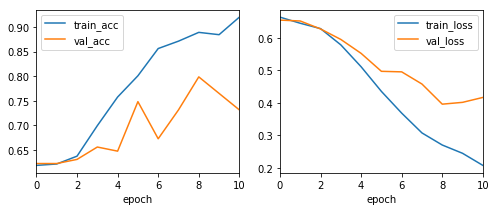

In [25]:

import matplotlib.pyplot as plt
import pandas as pd

# the fitting history is saved as dictionary
# covert the dictionary to dataframe
df=pd.DataFrame.from_dict(training.history)
df.columns=["val_loss", "val_acc","train_loss", "train_acc"]
df.index.name='epoch'
print(df)

# plot training history
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,3));

df[["train_acc", "val_acc"]].plot(ax=axes[0]);
df[["train_loss", "val_loss"]].plot(ax=axes[1]);
plt.show();

In [26]:

pred=model.predict(X_test)

# evaluate the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


accuracy: 73.11%
